In [3]:
# A1. Optional installs (commented out if you already installed)
# !pip install -q datasets transformers accelerate evaluate scikit-learn pandas numpy

# A2. Imports
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
import os
import random


In [4]:
# A3. Reproducibility helpers
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


In [5]:
# A4. Load the labeled PubMedQA split (1k yes/no/maybe)
labeled_data = load_dataset("pubmed_qa", "pqa_labeled")
print(labeled_data)

print("\nSample record:")
print(labeled_data["train"][0])


DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})

Sample record:
{'pubid': 21645374, 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?', 'context': {'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.', 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A 

In [6]:
# A5. Build a DataFrame: question + joined context + label
train_split = labeled_data["train"]

questions = [item["question"] for item in train_split]
contexts = [item["context"]["contexts"] for item in train_split]
labels = [item["final_decision"] for item in train_split]

# join multiple context paragraphs into one string
clean_contexts = [" ".join(pars) for pars in contexts]

# combined text representation
combined_text = [f"Q: {q}  Context: {ctx}" for q, ctx in zip(questions, clean_contexts)]

df = pd.DataFrame({
    "question": questions,
    "context": clean_contexts,
    "text": combined_text,
    "label": labels
})

# map labels to ids
label_map = {"no": 0, "yes": 1, "maybe": 2}
df["label_id"] = df["label"].map(label_map)

df.head()


,question,context,text,label,label_id
0,Do mitochondria play a role in remodelling lac...,Programmed cell death (PCD) is the regulated d...,Q: Do mitochondria play a role in remodelling ...,yes,1
1,Landolt C and snellen e acuity: differences in...,Assessment of visual acuity depends on the opt...,Q: Landolt C and snellen e acuity: differences...,no,0
2,"Syncope during bathing in infants, a pediatric...",Apparent life-threatening events in infants ar...,"Q: Syncope during bathing in infants, a pediat...",yes,1
3,Are the long-term results of the transanal pul...,The transanal endorectal pull-through (TERPT) ...,Q: Are the long-term results of the transanal ...,no,0
4,Can tailored interventions increase mammograph...,Telephone counseling and tailored print commun...,Q: Can tailored interventions increase mammogr...,yes,1


# 1) Visualizations before preprocessing (EDA on the DataFrame)

## 1.1 Class distribution (bar plot of labels)

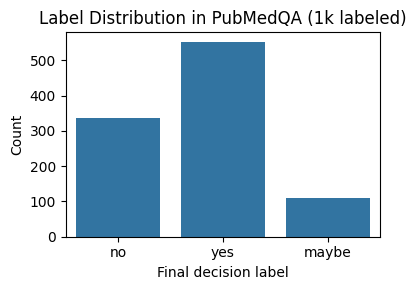

In [7]:
# Visualization 1: label distribution (class imbalance)
plt.figure(figsize=(4, 3))  # keep it small for report
sns.countplot(x="label", data=df, order=["no", "yes", "maybe"])  # bar for each class
plt.title("Label Distribution in PubMedQA (1k labeled)")
plt.xlabel("Final decision label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 1.2 Question / context length distributions

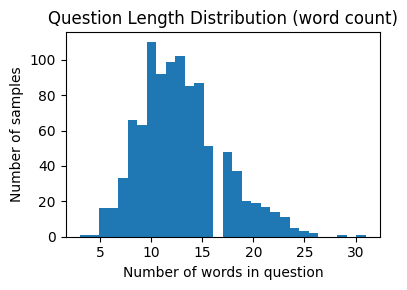

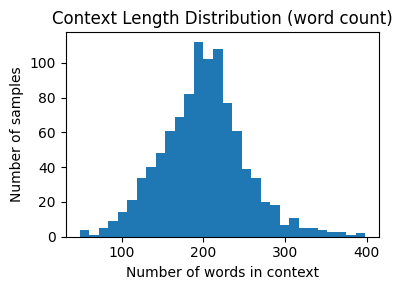

In [8]:
# Add simple length features for EDA
df["question_len"] = df["question"].str.split().apply(len)  # count words in question
df["context_len"] = df["context"].str.split().apply(len)  # count words in context

# Visualization 2: question length distribution
plt.figure(figsize=(4, 3))
plt.hist(df["question_len"], bins=30)  # histogram of question lengths
plt.title("Question Length Distribution (word count)")
plt.xlabel("Number of words in question")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

# Visualization 3: context length distribution
plt.figure(figsize=(4, 3))
plt.hist(df["context_len"], bins=30)  # histogram of context lengths
plt.title("Context Length Distribution (word count)")
plt.xlabel("Number of words in context")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()


## 1.3 Question vs context length (scatter)

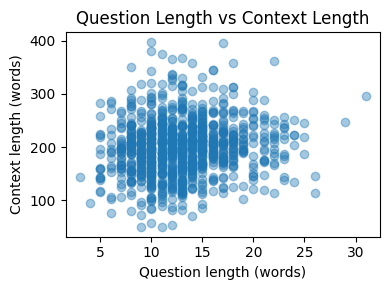

In [9]:
# Visualization 4 (optional): question vs context length
plt.figure(figsize=(4, 3))
plt.scatter(df["question_len"], df["context_len"], alpha=0.4)  # each point is one QA pair
plt.title("Question Length vs Context Length")
plt.xlabel("Question length (words)")
plt.ylabel("Context length (words)")
plt.tight_layout()
plt.show()


In [10]:
# A6. Train/validation split (80/20, stratified by label)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

print("\nClass distribution in training set:")
print(train_df["label"].value_counts())

print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())


Training samples: 800
Validation samples: 200

Class distribution in training set:
label
yes      442
no       270
maybe     88
Name: count, dtype: int64

Class distribution in validation set:
label
yes      110
no        68
maybe     22
Name: count, dtype: int64


In [11]:
# B1. TF-IDF features on combined "Q + context" text
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = vectorizer_tfidf.fit_transform(train_df["text"])
X_val_tfidf = vectorizer_tfidf.transform(val_df["text"])

y_train = train_df["label_id"].values
y_val = val_df["label_id"].values


In [12]:
# B2. Multinomial logistic regression baseline (improved)
logreg = LogisticRegression(
    max_iter=2000,              # give the solver more room to converge
    solver="lbfgs",             # good default for multinomial logistic regression
    class_weight="balanced",    # handle class imbalance so 'maybe' isn't ignored
    n_jobs=-1                   # use all cores if available
)

logreg.fit(X_train_tfidf, y_train)

y_pred_logreg = logreg.predict(X_val_tfidf)

acc_logreg = accuracy_score(y_val, y_pred_logreg)
print(f"Validation Accuracy (TF-IDF + Logistic Regression): {acc_logreg*100:.2f}%\n")

print("Classification Report (TF-IDF + Logistic Regression):")
print(classification_report(
    y_val,
    y_pred_logreg,
    target_names=["no", "yes", "maybe"],  # keep your label order
    zero_division=0                       # avoid UndefinedMetricWarning
))


Validation Accuracy (TF-IDF + Logistic Regression): 47.50%

Classification Report (TF-IDF + Logistic Regression):
              precision    recall  f1-score   support

          no       0.38      0.34      0.36        68
         yes       0.56      0.65      0.60       110
       maybe       0.08      0.05      0.06        22

    accuracy                           0.47       200
   macro avg       0.34      0.34      0.34       200
weighted avg       0.44      0.47      0.46       200



# 2) Visualizations after logistic regression (feature importance)

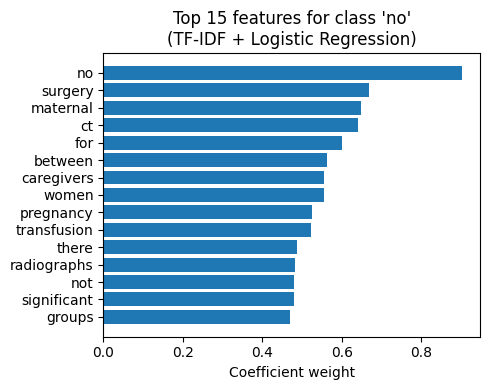

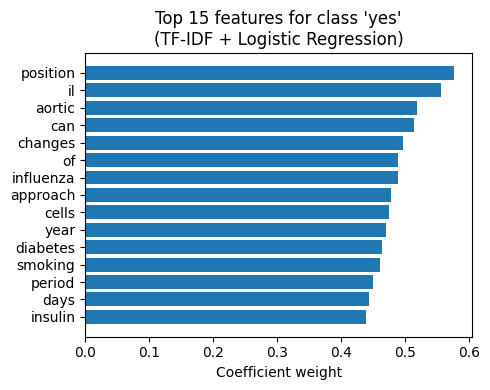

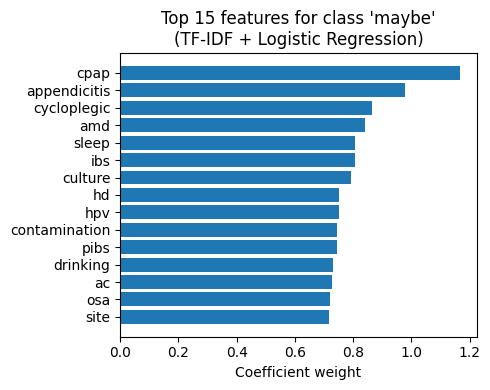

In [13]:
# Visualization 5: top TF-IDF features for each class (from logistic regression)
feature_names = vectorizer_tfidf.get_feature_names_out()  # vocabulary from TF-IDF

def plot_top_words_for_class(class_idx, class_name, top_n=15):
    coefs = logreg.coef_[class_idx]  # coefficients for this class
    top_indices = np.argsort(coefs)[-top_n:]  # indices of largest positive weights
    top_features = feature_names[top_indices]
    top_values = coefs[top_indices]

    plt.figure(figsize=(5, 4))
    plt.barh(range(len(top_features)), top_values)  # horizontal bar chart
    plt.yticks(range(len(top_features)), top_features)
    plt.title(f"Top {top_n} features for class '{class_name}'\n(TF-IDF + Logistic Regression)")
    plt.xlabel("Coefficient weight")
    plt.tight_layout()
    plt.show()

# Plot for each label
plot_top_words_for_class(0, "no")
plot_top_words_for_class(1, "yes")
plot_top_words_for_class(2, "maybe")


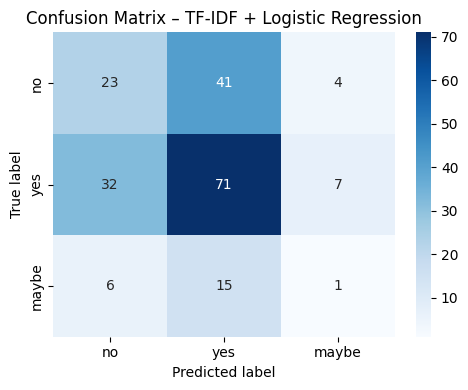

In [14]:
# B3. Confusion matrix for classical baseline
cm_logreg = confusion_matrix(y_val, y_pred_logreg)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_logreg,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["no", "yes", "maybe"],
    yticklabels=["no", "yes", "maybe"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – TF-IDF + Logistic Regression")
plt.tight_layout()
plt.show()


In [15]:
# C1. Prepare HuggingFace Dataset objects from train_df and val_df
hf_train = Dataset.from_pandas(train_df[["text", "label_id"]].reset_index(drop=True))
hf_val = Dataset.from_pandas(val_df[["text", "label_id"]].reset_index(drop=True))

# rename label column to "labels" for transformers Trainer
hf_train = hf_train.rename_column("label_id", "labels")
hf_val = hf_val.rename_column("label_id", "labels")

hf_train


Dataset({
    features: ['text', 'labels'],
    num_rows: 800
})

In [16]:
# C2. Load tokenizer and model (PubMedBERT)
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3  # no, yes, maybe
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# C3. Tokenization function
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

hf_train_tok = hf_train.map(tokenize_batch, batched=True)
hf_val_tok = hf_val.map(tokenize_batch, batched=True)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [18]:
# C4. Set torch format
hf_train_tok = hf_train_tok.remove_columns(["text"])
hf_val_tok = hf_val_tok.remove_columns(["text"])

hf_train_tok.set_format(type="torch")
hf_val_tok.set_format(type="torch")

hf_train_tok[0]


{'labels': tensor(2),
 'input_ids': tensor([    2,    59,    30, 10120,  3253,  4076,  1922,  4029,    17,  9663,
         24617,  1958,  6775,  2539,    30,  2112,  2038, 15360, 11396,  1990,
          3253,    17,  3575,  4391,    35,  4491,    30,  2876,  3253,    17,
          3776,  3673,  1922,  4029,    17,  9663, 24617,  2162,  5433,    43,
          2970,    16,  1920,  2485,  1927,  5545,    17,  8756,  9380,  1927,
          1920,  3080,  1935, 29148, 30338,  8362,    12, 27276,  1036,    13,
          4273,  2258,  2252,  3998,  4211,  1922,  1920,  6605,  1927, 10120,
          5312,    18,  1920,  3774,  1982,  1942,  4323,  2310, 20062,  2055,
            18, 24354,  2132,  2746,  4004,  4029,    17,  9663, 24617,  2256,
         10391,  8466,  9357,  4022,  1985,  3063,    18,  2079,  2311,    16,
          3369,  8581,  1985,  2593,  2019,  3000,    22,  1930,    23,    16,
          1956,  6605,  1927,  1920,  3754, 22708,  6490,  1930,  3586,    18,
          5312,  

In [19]:
# C5. Metric: accuracy
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)


In [20]:
# C6. Disable W&B logging if present
os.environ["WANDB_DISABLED"] = "true"

# C7. TrainingArguments for baseline PubMedBERT
training_args_baseline = TrainingArguments(
    output_dir="./results_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    logging_strategy="steps",
    logging_steps=50
)

trainer_baseline = Trainer(
    model=model,
    args=training_args_baseline,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)


In [21]:
# C8. Train PubMedBERT baseline
set_seed(42)
train_result = trainer_baseline.train()
print(train_result)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.926500,0.854893,0.620000
2,0.761700,0.837749,0.635000
3,0.653800,0.881352,0.650000


TrainOutput(global_step=300, training_loss=0.7948246892293295, metrics={'train_runtime': 40.2055, 'train_samples_per_second': 59.693, 'train_steps_per_second': 7.462, 'total_flos': 315736101273600.0, 'train_loss': 0.7948246892293295, 'epoch': 3.0})


# 3) Visualizations after BERT training (learning curves)

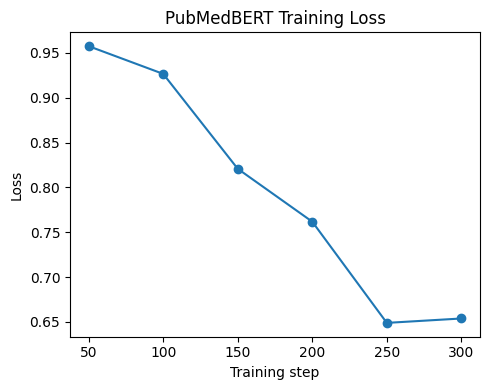

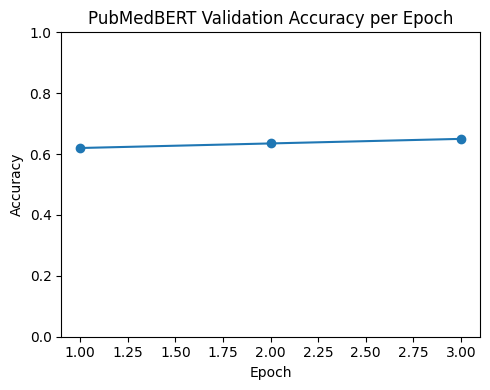

In [22]:
# Visualization 6: training loss and validation accuracy over time for PubMedBERT
logs = trainer_baseline.state.log_history  # list of dicts with 'loss', 'eval_accuracy', etc.

# Collect training loss logs
train_steps = [x["step"] for x in logs if "loss" in x]
train_loss = [x["loss"] for x in logs if "loss" in x]

# Collect evaluation accuracy logs
eval_epochs = [x["epoch"] for x in logs if "eval_accuracy" in x]
eval_accuracy = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]

plt.figure(figsize=(5, 4))
plt.plot(train_steps, train_loss, marker="o")  # training loss vs step
plt.title("PubMedBERT Training Loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(eval_epochs, eval_accuracy, marker="o")  # eval accuracy vs epoch
plt.title("PubMedBERT Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [23]:
# C9. Evaluate PubMedBERT baseline
eval_result_baseline = trainer_baseline.evaluate()
print("Baseline PubMedBERT eval result:", eval_result_baseline)


Baseline PubMedBERT eval result: {'eval_loss': 0.8813515305519104, 'eval_accuracy': 0.65, 'eval_runtime': 0.9395, 'eval_samples_per_second': 212.868, 'eval_steps_per_second': 26.608, 'epoch': 3.0}


Validation Accuracy (PubMedBERT baseline): 65.00%

Classification Report (PubMedBERT baseline):
              precision    recall  f1-score   support

          no       0.57      0.59      0.58        68
         yes       0.69      0.82      0.75       110
       maybe       0.00      0.00      0.00        22

    accuracy                           0.65       200
   macro avg       0.42      0.47      0.44       200
weighted avg       0.58      0.65      0.61       200



C:\Users\rando\anaconda3\envs\torch121\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rando\anaconda3\envs\torch121\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rando\anaconda3\envs\torch121\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

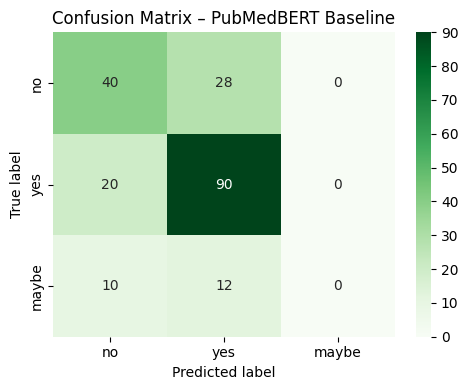

In [24]:
# C10. Detailed metrics: classification report + confusion matrix
pred_output = trainer_baseline.predict(hf_val_tok)
logits = pred_output.predictions
labels_true = pred_output.label_ids
y_pred_baseline = np.argmax(logits, axis=-1)

acc_baseline = accuracy_score(labels_true, y_pred_baseline)
print(f"Validation Accuracy (PubMedBERT baseline): {acc_baseline*100:.2f}%\n")

print("Classification Report (PubMedBERT baseline):")
print(classification_report(
    labels_true,
    y_pred_baseline,
    target_names=["no", "yes", "maybe"]
))

cm_baseline = confusion_matrix(labels_true, y_pred_baseline)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["no", "yes", "maybe"],
    yticklabels=["no", "yes", "maybe"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – PubMedBERT Baseline")
plt.tight_layout()
plt.show()


C:\Users\rando\AppData\Local\Temp\ipykernel_2768\2597765439.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


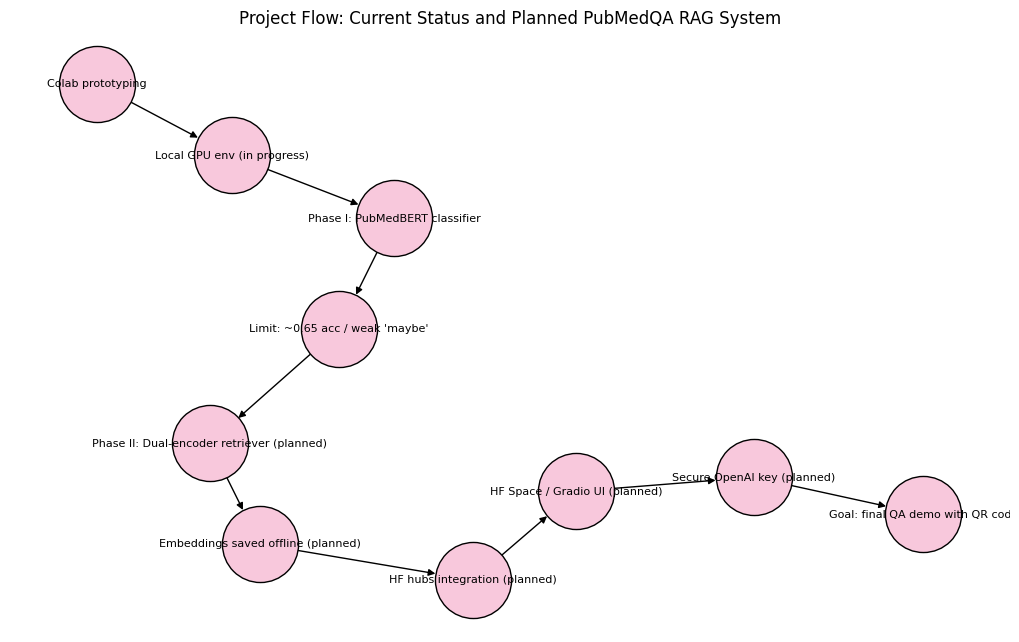

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# This graph shows the high-level project flow from what is done now to the planned next steps.
G = nx.DiGraph()

# Nodes (short labels; later steps clearly marked as planned/goal)
G.add_nodes_from([
    "Colab prototyping",
    "Local GPU env (in progress)",
    "Phase I: PubMedBERT classifier",
    "Limit: ~0.65 acc / weak 'maybe'",
    "Phase II: Dual-encoder retriever (planned)",
    "Embeddings saved offline (planned)",
    "HF hubs integration (planned)",
    "HF Space / Gradio UI (planned)",
    "Secure OpenAI key (planned)",
    "Goal: final QA demo with QR code"
])

# Edges to indicate the intended story flow
edges = [
    ("Colab prototyping", "Local GPU env (in progress)"),
    ("Local GPU env (in progress)", "Phase I: PubMedBERT classifier"),
    ("Phase I: PubMedBERT classifier", "Limit: ~0.65 acc / weak 'maybe'"),
    ("Limit: ~0.65 acc / weak 'maybe'", "Phase II: Dual-encoder retriever (planned)"),
    ("Phase II: Dual-encoder retriever (planned)", "Embeddings saved offline (planned)"),
    ("Embeddings saved offline (planned)", "HF hubs integration (planned)"),
    ("HF hubs integration (planned)", "HF Space / Gradio UI (planned)"),
    ("HF Space / Gradio UI (planned)", "Secure OpenAI key (planned)"),
    ("Secure OpenAI key (planned)", "Goal: final QA demo with QR code")
]

G.add_edges_from(edges)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    font_size=8,
    node_color="#f8c8dc",  # pale pink
    edgecolors="black"
)

plt.title("Project Flow: Current Status and Planned PubMedQA RAG System")
plt.axis("off")
plt.tight_layout()
plt.show()
